# Preprocessing script

The task of this script is to perform the preprocessing of the input data

In [1]:
# import all the required packages

import PIL 
from PIL import Image
from __future__ import print_function
import os
import numpy as np
from scipy import ndimage # required for loading images into the dataset
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
# set the paths required for the script to work:
root = "../Data/"
pindown_path = os.path.join(root,"PinDown__precisionistprecisionism-art")

## Perform the resizing of all the images:
the input images do not have a standard size, so we will have to resize them and use them accordingly

In [3]:
# The following function converts all the images to standard sized images
def resize(path, ori_path, size):
    # counters for processed files
    count = 0 
    faulty_files = 0
    
    # check if the directory already exists 
    if(not os.path.exists(path)):
        os.mkdir(path)
        
        folders = sorted(os.listdir(ori_path)) 
        for folder in folders:
            
            images = sorted(os.listdir(os.path.join(ori_path, folder)))
        
            for image in images:
                image_file_path = ori_path + "/" + folder + "/" + image
                try:
                    img = Image.open(image_file_path) # throws IOError    
                    img = img.resize((size, size), PIL.Image.ANTIALIAS)
                    img.save(path + "/" + folder + "%" + image)

                except IOError: # if IOError is thrown, then the image is faulty
                    print("image %s is faulty" %(image_file_path))
                    faulty_files += 1 
                    continue


                if(count % 100 == 0):
                    print("Working on %dth image" %(count))

                count += 1

    else:
        print("path %s already exists" %(path))
    
    # print the statistical output of the process
    print("Total Files normalized: %d\nFaulty Files: %d\n" %(count, faulty_files))

In [4]:
# convert the training images to 100 x 100 sized images: 
resize(os.path.join(root, "resized_pindown_images"), pindown_path, 100)

path ../Data/resized_pindown_images already exists
Total Files normalized: 0
Faulty Files: 0



In [5]:
# set the path for the resized images
resized_images_path = os.path.join(root, "resized_pindown_images")

'''Set a few constants for the further script'''

image_size = 100  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
image_depth = 3 # coloured images in RGB format 

## Load the image based data into ND-Array:
the input images are in RGB format; so we will extract the data from the R, G and B channel and load them as numpy arrays.

In [6]:
def load_data(folder, min_num_images, MeanNormalize=False):
    """Load the data from the provided folder"""
    # get all the images from the folder
    image_files = os.listdir(folder)

    # create n dimensional arrays for the images and their numbers
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size, image_depth),
                         dtype=np.float32) 
    
    image_labels = []
    
    print("Loading Images from %s" %folder) # feedback message
  
    num_images = 0 # counter for number of images
    
    for image in image_files: # enter the main loop
        image_file = os.path.join(folder, image) # path of file 
        try:
            # normalize the image pixel values around its mean
            if MeanNormalize:
                image_data = (ndimage.imread(image_file).astype(float) - 
                            pixel_depth / 2) / pixel_depth
            else:
                image_data = ndimage.imread(image_file).astype(float)
            
            if image_data.shape != (image_size, image_size, image_depth):#removing grayscale images
                print('Unexpected image shape: %s of image %s\nIts ok, skipping it' % 
                                (str(image_data.shape), image_file))
                continue
            
            dataset[num_images, :, :, :] = image_data
            
            # extract the label and assign it.
            label = image.split("%")[0].split("__")[1]
            
            image_labels.append(label)
                            
            num_images = num_images + 1
        except IOError as e:
              print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :, :] # exclude the place holder for the faulty images
    image_labels = image_labels[0: num_images]
    
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %(num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset, image_labels

In [7]:
# load the Resized images
try:
    train_dataset, train_labels = load_data(resized_images_path, 2000)
    
except Exception as e:
    print('Error occured: ', e)

Loading Images from ../Data/resized_pindown_images
Unexpected image shape: (100, 100) of image ../Data/resized_pindown_images/PinDown__art--Expressionism%75bd9f544f7a3a7916ceb0edeb9d7dd6.jpg
Its ok, skipping it
Unexpected image shape: (100, 100) of image ../Data/resized_pindown_images/PinDown__Minimalism-Art%cf68e4df7f619d32f461085cc804683a.jpg
Its ok, skipping it
Unexpected image shape: (100, 100) of image ../Data/resized_pindown_images/PinDown__Op-Art%030daf00cfed2916e84cca6a5c74e3fb.jpg
Its ok, skipping it
Unexpected image shape: (100, 100) of image ../Data/resized_pindown_images/PinDown__Op-Art%c9e86a2e8284138d743bc5ca6800cac8.jpg
Its ok, skipping it
Unexpected image shape: (100, 100) of image ../Data/resized_pindown_images/PinDown__Minimalism-Art%1f6112c597805d3a71ccdcff278a407e.jpg
Its ok, skipping it
Unexpected image shape: (100, 100) of image ../Data/resized_pindown_images/PinDown__Minimalism-Art%bb088ec4fd78d2bc6dd9d240f0ae9879.jpg
Its ok, skipping it
Unexpected image shape: (

In [8]:
train_labels[10: 20]

['Action-Painting',
 'Op-Art',
 'Op-Art',
 'Cubism',
 'Post-impressionism',
 'Post-impressionism',
 'Hard-Edge-Art',
 'Minimalism-Art',
 'art--Expressionism',
 'Cubism']

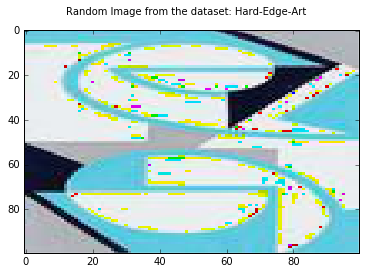

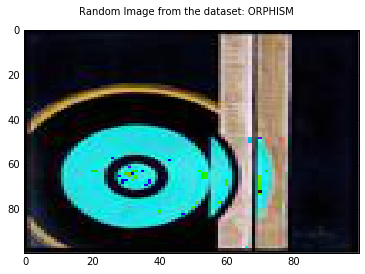

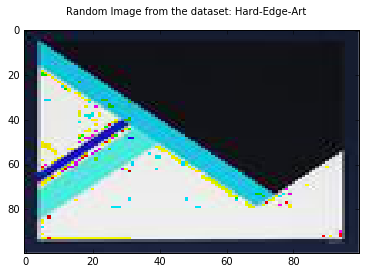

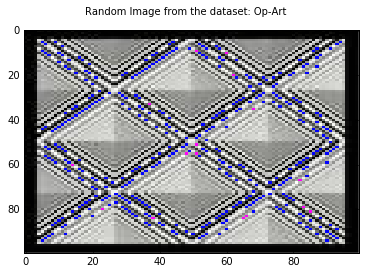

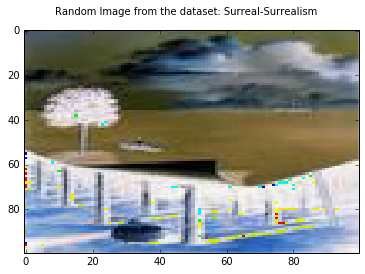

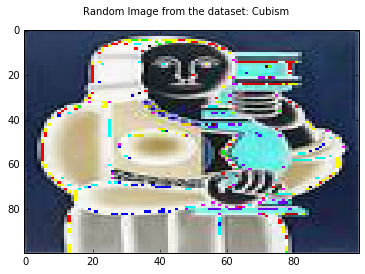

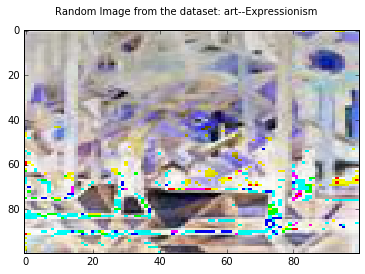

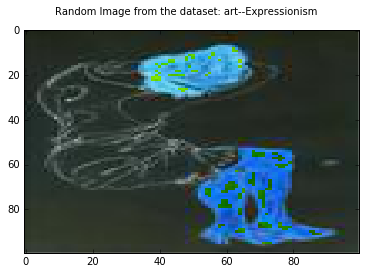

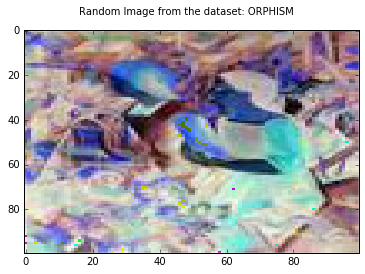

In [9]:
# display 10 random images from the numpy version of the dataset
for i in range(1, 10):
    random_index = np.random.randint(train_dataset.shape[0])
    
    label = train_labels[random_index]
    
    plt.figure().suptitle("Random Image from the dataset: %s" %(label))
    plt.imshow(train_dataset[random_index], interpolation='none', aspect='auto')


## Pickling the preprocessed data:
We will now generate one hot encoded labels and then pickle the data into a pickle file

In [10]:
# create a dictionary of mapping from labels to data encoders
label_mappings = dict(enumerate(sorted(set(train_labels))))

# reverse the mappings
label_mappings = dict([(label_mappings[k], k) for k in label_mappings.keys()])

# just for fun:
label_mappings

{'Action-Painting': 0,
 'Colour-Field-Painting': 1,
 'Cubism': 2,
 'Hard-Edge-Art': 3,
 'Minimalism-Art': 4,
 'ORPHISM': 5,
 'Op-Art': 6,
 'Post-impressionism': 7,
 'Surreal-Surrealism': 8,
 'art--Expressionism': 9}

In [11]:
# function to hot encode the labels
def hot_encode(labels):
    encoded_labels = [[0 for i in range(0, len(label_mappings))] for j in range(0, len(labels))]
    for i in range(0, len(labels)):
        encoded_labels[i][label_mappings[labels[i]]] = 1
    return np.array(encoded_labels, dtype=np.float32)

In [12]:
encoded_train_labels = hot_encode(train_labels)
# print a few encoded and non encoded train_labels
print(train_labels[:6])
encoded_train_labels[:6]

['Cubism', 'Op-Art', 'Op-Art', 'ORPHISM', 'Action-Painting', 'Colour-Field-Painting']


array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [13]:
''' For pickling the data acquired till now '''

# data dictionary


training_percentage = 70
cross_validation_percentage = 10
# remaining = test data

train_partition = (len(train_dataset) * training_percentage) / 100
cv_partition = (len(train_dataset) * (training_percentage + cross_validation_percentage)) / 100

data_dict = {
    "train_data" : train_dataset[: train_partition],
    "train_labels" : encoded_train_labels[: train_partition],
    "cv_data" : train_dataset[train_partition: cv_partition],
    "cv_labels" : encoded_train_labels[train_partition: cv_partition],
    "test_data" : train_dataset[cv_partition : ],
    "test_labels" : encoded_train_labels[cv_partition : ],
    
    "label_mapping" : label_mappings
}

if(not os.path.isfile(os.path.join(root, "Data_pindown.pickle"))):
    with open(os.path.join(root, "Data_pindown.pickle"), "wb") as pickle_file:
        pickle.dump(data_dict, pickle_file, pickle.HIGHEST_PROTOCOL)
        print("Pickling complete")
        
else:
    print("data is already pickled")

Pickling complete


In [14]:
# naive checking of the integrity of the pickled data

with open(os.path.join(root, "Data_pindown.pickle"), "rb") as pickle_file:
    my_dict = pickle.load(pickle_file)
    
len(my_dict)

7